**Importing dependencies:**



In [ ]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import os
import sys
import time
import math

**Data processing:**
We augment the data using random crops and horizontal flips. These augmentation are not applied to the test set.
All the data is also normalized using Z-score formula.

In [ ]:
data_statistics = [(0.5,0.5,0.5),(0.5,0.5,0.5)]
trainset_transforms_cifar= transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'), #data augmentation step 1: random croppings
    transforms.RandomHorizontalFlip(), #data augmentation step 2: random horizontal flips
    transforms.ToTensor(), # the images are represented as C*H*W
    transforms.Normalize(*data_statistics, inplace=True) #data normalization
])
testset_transforms_cifar= transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(*data_statistics, inplace=True)
])


In [ ]:
dataset = torchvision.datasets.CIFAR10(root="\data",download=True, transform=trainset_transforms_cifar)
test_dataset = torchvision.datasets.CIFAR10(root="\data",download=False, transform=testset_transforms_cifar)

Files already downloaded and verified


In [ ]:
batch_size=80
validation_ratio=0.2
train_dataset, validation_dataset = random_split(dataset,[int((1-validation_ratio)*len(dataset)),int(validation_ratio*len(dataset))])
trainset_dl = DataLoader(train_dataset,batch_size, shuffle=True,pin_memory=True)
validationset_dl = DataLoader(validation_dataset,batch_size, shuffle=True,pin_memory=True)
testset_dl = DataLoader(test_dataset,batch_size, pin_memory=True)

The images appear darker than normal due to the normalization.

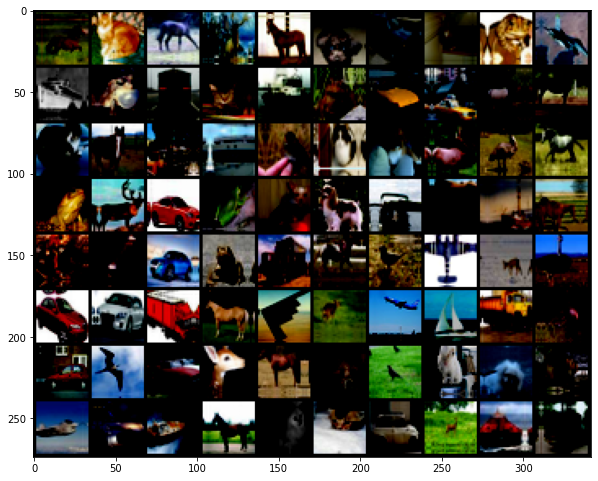

In [ ]:
def show_batch_images(dl):
  for images, labels in dl: 
    figure, axe = plt.subplots(figsize=(10,10))
    axe.imshow(make_grid(images,10).permute(1,2,0)) 
    break

show_batch_images(trainset_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
train_dl = DeviceDataLoader(trainset_dl, device)
valid_dl = DeviceDataLoader(validationset_dl, device)
test_dl= DeviceDataLoader(testset_dl, device)
device

device(type='cuda')

**Model architecture:**
Code referenced from this [tutorial](https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/)

In [ ]:
# Network implementation inspired by PyTorch tutorial
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


Training: 
We will perform the classification using the resnet18 architecture.
- *epochs*:200
- *learning rate*:0.1. we rescale the learning rate by a 0.1 factor at steps 80 and 150
- *loss function*: cross entropy
- *optimizer*: SGD

In [ ]:
def accuracy(preds,labels):
  pred, pred_class_ID = torch.max(preds,dim=1)
  return torch.tensor(torch.sum(pred_class_ID == labels ).item()/len(preds))


In [ ]:
#used to update the learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
def evaluate_model(model,dl,loss_func):
  model.eval()
  batch_losses, batch_accs = [],[]
  for images, labels in dl:
    with torch.no_grad():
        preds=model(images)
    batch_losses.append(loss_function(preds, labels))
    batch_accs.append(accuracy(preds,labels))
  epoch_avg_loss=torch.stack(batch_losses).mean()
  epoch_avg_acc=torch.stack(batch_accs).mean()
  return epoch_avg_loss, epoch_avg_acc

In [ ]:
def train_model(model, train_dl,val_dl,epochs,learning_rate,loss_function,optim):
  optimizer = optim(model.parameters(),learning_rate)
  res = []
  for epoch in range(epochs):
    model.train()
    train_losses = []
    lrs = []
    curr_rate=learning_rate
    for images, labels in train_dl:
      preds = model(images)
      loss = loss_function(preds,labels)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      lrs.append(optimizer.param_groups[0]["lr"])
      if (epoch+1) in [80, 150]:#we rescale the learning rate by a 0.1 factor at steps 80 and 150
        curr_rate = curr_rate*0.1
        update_lr(optimizer, curr_rate)
    epoch_train_loss=torch.stack(train_losses).mean().item()
    epoch_avg_loss, epoch_avg_acc =evaluate_model(model,val_dl,loss_function)
  res.append({'avg_valid_loss':epoch_avg_loss,'avg_valid_acc':epoch_avg_acc,'avg_train_loss':epoch_train_loss})
  return res

In [ ]:
model = to_device(ResNet(ResidualBlock, [2, 2, 2]),device)
epochs=200
learning_rate=0.1
loss_function=nn.CrossEntropyLoss()
optimizer= torch.optim.SGD


In [ ]:
%%time 
results=train_model(model, train_dl,valid_dl,epochs,learning_rate,loss_function,optimizer)
for res in results: 
  print(res['avg_valid_acc'])

tensor(0.8726)
CPU times: user 1h 36min 16s, sys: 23.6 s, total: 1h 36min 39s
Wall time: 1h 36min 25s


In [ ]:
_,test_acc = evaluate_model(model,test_dl, loss_function)


In [ ]:
print(test_acc)

tensor(0.9491)


In [ ]:
torch.save(model.state_dict(),"cifar10_rexnet18.pth")